In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from models import MyLSTM, MyGRU

window 36, 36, horizon 36

In [6]:
!gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'


Downloading...
From: https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN
To: /content/train.zip
100% 8.67M/8.67M [00:00<00:00, 51.4MB/s]


In [7]:
!gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

Downloading...
From: https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i
To: /content/test.zip
100% 459k/459k [00:00<00:00, 5.61MB/s]


In [11]:
!unzip 'train.zip' -d '.'

Archive:  train.zip
replace ./tps_df.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
!unzip 'test.zip' -d '.'

Archive:  test.zip
  inflating: ./test_data/tps_5.pkl   
  inflating: ./test_data/tps_2.pkl   
  inflating: ./test_data/tps_6.pkl   
  inflating: ./test_data/tps_4.pkl   
  inflating: ./test_data/tps_15.pkl  
  inflating: ./test_data/tps_7.pkl   
  inflating: ./test_data/tps_1.pkl   
  inflating: ./test_data/tps_12.pkl  
  inflating: ./test_data/tps_8.pkl   
  inflating: ./test_data/tps_3.pkl   
  inflating: ./test_data/tps_9.pkl   
  inflating: ./test_data/tps_13.pkl  
  inflating: ./test_data/tps_11.pkl  
  inflating: ./test_data/tps_10.pkl  
  inflating: ./test_data/tps_14.pkl  


In [4]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        #split it into training and test 80 20
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill") # 1 nan nan nan 2, fulfill 2
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            #split it into training and test 80 20
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]
                h = h_series[t:t+self.window]
                x_cat = np.dstack([x, h])
                self.inputs.append(x_cat)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window, 2)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [ ]:
# [123]
# [234]
# [345]
# 1*36*2 hour

In [5]:
tobj = TrafficForecast('tps_df.pkl',36,36) #window and forcast

In [6]:
bs = 1024
dataloader_train = DataLoader(tobj, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break


torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 1/3 [03:01<06:03, 181.72s/it]

Epoch 1/3, Training Loss: 0.0542


 67%|██████▋   | 2/3 [06:03<03:01, 181.73s/it]

Epoch 2/3, Training Loss: 0.0328


100%|██████████| 3/3 [09:12<00:00, 184.11s/it]

Epoch 3/3, Training Loss: 0.0257


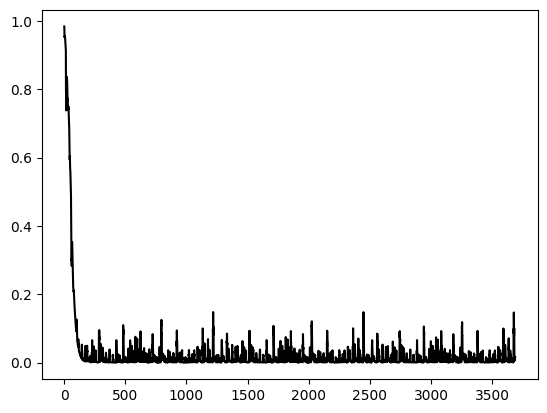

In [14]:
plt.plot(losses,'k',label='training')

In [15]:
torch.save(model.state_dict(), 'grumodel.pt')

In [17]:
# model_arch = SimpleGRU(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
# model_arch.load_state_dict(torch.load('grumodel.pt'))
# model_arch.eval()